# Measuring graphic properties of logos using computer vision

Let's start by importing libraries such as [OpenCV](http://opencv.org/), matplotlib and turning on in-line plotting.

In [1]:
import cv2
import imutils
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

%matplotlib inline

Let's load the example logo.

In [2]:
img = cv2.imread('topaz_logo.jpg')

The image is now represented by a matrix containing pixel values for blue, red and green channels (that's the order for OpenCV). We can check the shape of the matrix using the .shape attribute.

In [3]:
img.shape

(320, 241, 3)

Let's convert the image to grayscale before further processing.

In [4]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

Add a bit of Gaussian blur to get rid of sharp edges in the image.

In [5]:
blurred = cv2.GaussianBlur(gray, (3, 3), 0)

Next, let's attempt to separate background and foreground elements from the image using *thresholding*.

In order to define a manual value for thresholding, let's use **Otsu's method** for calculating a **global** threshold.

All pixels whose value is below the threshold will be set to zero, whereas those above the threshold will be set to 255 (white).

In [6]:
(threshold_value, thresholded_image) = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)

print("Otsu's threshold: {}".format(threshold_value))

Otsu's threshold: 155.0


Let's take a look at the thresholded image. Note that we need to convert the colours to render the image correctly using matplotlib.

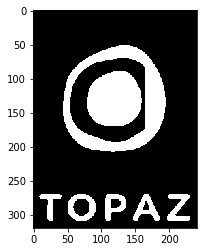

In [7]:
plt.imshow(cv2.cvtColor(thresholded_image, cv2.COLOR_GRAY2RGB))

Let's use the thresholded image as a mask and dump it on top of the original.

In [8]:
masked = cv2.bitwise_and(img, img, mask=thresholded_image)

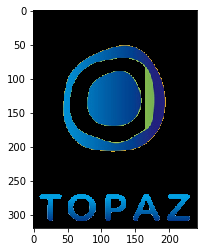

In [9]:
plt.imshow(cv2.cvtColor(masked, cv2.COLOR_BGR2RGB))

Otsu's method seems to miss some of the details.

Let's try **adaptive thresholding** for a change and calculate a **local** threshold for each 25 x 25 pixel grid in the image.

In [10]:
a_thresh = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 25, 15)

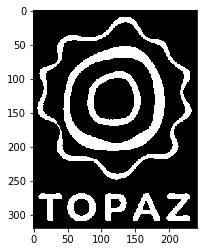

In [11]:
plt.imshow(cv2.cvtColor(a_thresh, cv2.COLOR_GRAY2RGB))

Looks much better.

Let's find some contours in the image and then use the *imutils* library to process them.

In [12]:
contours = cv2.findContours(a_thresh.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

contours = imutils.grab_contours(contours)

We can then draw the contours on the original image. Note that we should copy the image, as the process is destructive.

In [13]:
contours_img = cv2.drawContours(img.copy(), contours, -1, (0, 0, 255), 2)

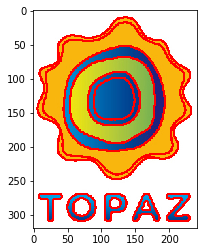

In [14]:
plt.imshow(cv2.cvtColor(contours_img, cv2.COLOR_BGR2RGB))

There are many different ways of extracting contours. We can either get a list of all contours (`cv2.RETR_LIST`) or external contours only (`cv2.RETR_EXTERNAL`).

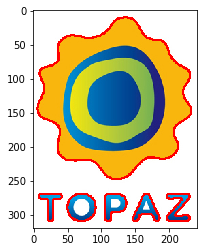

In [15]:
# Find contours
ext_contours = cv2.findContours(a_thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Filter the result using imutils
ext_contours = imutils.grab_contours(ext_contours)

# Draw contours on a copy of the original image
ext_contours_img = cv2.drawContours(img.copy(), ext_contours, -1, (0, 0, 255), 2)

# Convert the colour space and render using matplotlib
plt.imshow(cv2.cvtColor(ext_contours_img, cv2.COLOR_BGR2RGB))

We can also get a hierarchy of contours, which indicates which contours are nested within one another using `cv2.RETR_TREE`.

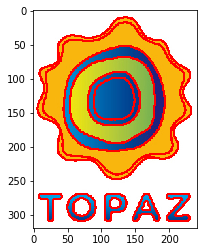

In [16]:
# Find contours
tree_contours_orig = cv2.findContours(a_thresh.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Filter the result using imutils
tree_contours = imutils.grab_contours(tree_contours_orig)

# Draw contours on a copy of the original image
tree_contours_img = cv2.drawContours(img.copy(), tree_contours, -1, (0, 0, 255), 2)

# Convert the colour space and render using matplotlib
plt.imshow(cv2.cvtColor(tree_contours_img, cv2.COLOR_BGR2RGB))

We can fetch the contour hierarchy from the original output of `cv2.RETR_TREE`. It is a matrix stored at index `2`.

Let's unpack the result a bit. Each contour is represented by a vector of four values:

1. The first value gives the *next contour* on the same level of hierarchy. `-1` indicates that there is no more contours on the same level.
2. The second value gives the previous contour on the same level of hierarchy. `-1` indicates that there is no previous contour.
3. The third value gives the index of the child of this contour. Again, `-1` indicates no children.
4. The fourth value gives the parent of the contour. `-1` indicates no parents.

So for the first item in the contour list, the next contour is at index `1`, but there are no previous contours, nor children or parent contours.

In [17]:
hierarchy = tree_contours_orig[2]

hierarchy

array([[[ 1, -1, -1, -1],
        [ 3,  0,  2, -1],
        [-1, -1, -1,  1],
        [ 5,  1,  4, -1],
        [-1, -1, -1,  3],
        [ 7,  3,  6, -1],
        [-1, -1, -1,  5],
        [ 8,  5, -1, -1],
        [-1,  7,  9, -1],
        [-1, -1, 10,  8],
        [-1, -1, 11,  9],
        [-1, -1, 12, 10],
        [-1, -1, 13, 11],
        [-1, -1, -1, 12]]], dtype=int32)

Let's draw the first contour (at index `0`) and check the result.

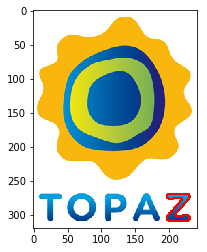

In [18]:
# Draw contours on a copy of the original image
single_contour_img = cv2.drawContours(img.copy(), tree_contours, 0, (0, 0, 255), 2)

# Convert the colour space and render using matplotlib
plt.imshow(cv2.cvtColor(single_contour_img, cv2.COLOR_BGR2RGB))

Let's get the number of contours, which is stored in the second dimension of the `hierarchy` matrix.

Also, let's get the children of each contour.

In [19]:
# Number of contours
n_contours = hierarchy.shape[1]

# Children of each contour
children = hierarchy[:,:,3].flatten()

# Contours in the top-level hierarchy
top_level = hierarchy[:,:,1].flatten()

Next, let's create a graph to represent the relations between contours.

In [20]:
# Initialise graph
graph = nx.Graph()

# Add nodes from 0 to the number of contours
graph.add_nodes_from([x for x in range(0, n_contours)])

Next, we add edges between the nodes according to the information about contour children.

In [21]:
# Loop over the list of nodes and their children
for node in list(graph.nodes):

    # Check if the index of chidren is not -1 (no children)
    if children[node] != -1:
        
        # If a child exists, add edge between child and parent
        graph.add_edge(children[node], node)

    # Check if the node is on the highest level of the hierarchy
    if children[node] == -1:
        
        # If the node is on the top-level, add edge to root node
        graph.add_edge(node, "logo")

Finally, let's visualize the graph.

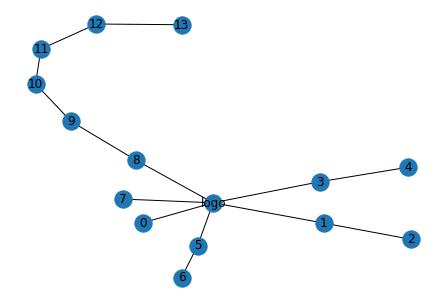

In [22]:
nx.draw(graph, with_labels=True)
plt.show(graph)